# Random Forest for Carrot Price Prediction
## 4th Year Academic Research - Model Comparison

**Dataset:** Dambulla Market Carrot Prices (2020-2025)

**Goal:** Compare Random Forest with LSTM models

**Benchmark to beat:** Bidirectional LSTM - 19.30% MAPE

---

## Contents
1. Data Loading & Preprocessing
2. Feature Engineering
3. Feature Selection
4. Random Forest - Basic Model
5. Hyperparameter Tuning
6. Feature Importance Analysis
7. Model Comparison (vs LSTM)
8. Visualizations & Export

In [ ]:
# Install packages
!pip install scikit-learn matplotlib seaborn pandas numpy joblib -q
print("✅ Packages installed")

✅ Packages installed


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print("✅ All packages loaded successfully")

✅ All packages loaded successfully


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Successfully mounted!")

Mounted at /content/drive
Successfully mounted!


## PART A: DATA LOADING & PREPROCESSING

In [ ]:
csv_file_path = "/content/drive/MyDrive/RESEARCH-ALL-in-one/ALL-Data-in-one-CSV/best-dataset/dambulla_market_dataset.csv"

df = pd.read_csv(csv_file_path, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)
df.set_index("date", inplace=True)

print("="*60)
print("📊 DATA LOADED")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Columns: {len(df.columns)}")
print(f"Target variable: carrot_price")
print(f"  Min: {df['carrot_price'].min():.2f} Rs")
print(f"  Max: {df['carrot_price'].max():.2f} Rs")
print(f"  Mean: {df['carrot_price'].mean():.2f} Rs")
print(f"  Std: {df['carrot_price'].std():.2f} Rs")

📊 DATA LOADED
Shape: (2017, 46)
Date range: 2020-01-01 00:00:00 to 2025-07-11 00:00:00
Columns: 46
Target variable: carrot_price
  Min: 53.00 Rs
  Max: 1950.00 Rs
  Mean: 236.80 Rs
  Std: 177.85 Rs


In [ ]:
# Data quality check
print("="*60)
print("🔍 DATA QUALITY CHECK")
print("="*60)

missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"⚠️ Missing values found:")
    print(missing[missing > 0])
else:
    print("✅ No missing values")

# Check outliers
Q1 = df['carrot_price'].quantile(0.25)
Q3 = df['carrot_price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['carrot_price'] < Q1 - 1.5*IQR) | (df['carrot_price'] > Q3 + 1.5*IQR)]
print(f"\n📉 Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

print(f"\n✅ Data quality check complete")

🔍 DATA QUALITY CHECK
✅ No missing values

📉 Outliers: 103 (5.11%)

✅ Data quality check complete


In [ ]:
# Transform supply factors: 1→2 (high), -1→1 (normal), 0→0 (low)
supply_cols = [col for col in df.columns if 'supply_factor' in col]
df_transformed = df.copy()
supply_mapping = {1: 2, -1: 1, 0: 0}

for col in supply_cols:
    df_transformed[col] = df_transformed[col].map(supply_mapping)

print(f"✅ Transformed {len(supply_cols)} supply factor columns")
print(f"   Encoding: 2=HIGH, 1=NORMAL, 0=LOW")

✅ Transformed 15 supply factor columns
   Encoding: 2=HIGH, 1=NORMAL, 0=LOW


## PART B: FEATURE ENGINEERING

**Note:** Random Forest doesn't use sequences like LSTM. Instead, we create lag features and rolling statistics as regular columns.

In [ ]:
print("="*60)
print("🔧 FEATURE ENGINEERING FOR RANDOM FOREST")
print("="*60)

df_features = df_transformed.copy()

# ============================================
# 1. PRICE LAG FEATURES
# ============================================
print("\n1️⃣ Creating price lag features...")
df_features['price_lag_1'] = df_features['carrot_price'].shift(1)
df_features['price_lag_2'] = df_features['carrot_price'].shift(2)
df_features['price_lag_3'] = df_features['carrot_price'].shift(3)
df_features['price_lag_7'] = df_features['carrot_price'].shift(7)
df_features['price_lag_14'] = df_features['carrot_price'].shift(14)
df_features['price_lag_21'] = df_features['carrot_price'].shift(21)
df_features['price_lag_30'] = df_features['carrot_price'].shift(30)

# Rolling statistics
df_features['price_rolling_mean_7'] = df_features['carrot_price'].rolling(window=7, min_periods=1).mean()
df_features['price_rolling_mean_14'] = df_features['carrot_price'].rolling(window=14, min_periods=1).mean()
df_features['price_rolling_mean_30'] = df_features['carrot_price'].rolling(window=30, min_periods=1).mean()
df_features['price_rolling_std_7'] = df_features['carrot_price'].rolling(window=7, min_periods=1).std()
df_features['price_rolling_std_14'] = df_features['carrot_price'].rolling(window=14, min_periods=1).std()
df_features['price_rolling_min_7'] = df_features['carrot_price'].rolling(window=7, min_periods=1).min()
df_features['price_rolling_max_7'] = df_features['carrot_price'].rolling(window=7, min_periods=1).max()
df_features['price_rolling_median_7'] = df_features['carrot_price'].rolling(window=7, min_periods=1).median()

# Price changes
df_features['price_change'] = df_features['carrot_price'].diff()
df_features['price_change_pct'] = df_features['carrot_price'].pct_change()
df_features['price_change_7d'] = df_features['carrot_price'].diff(7)
df_features['price_change_14d'] = df_features['carrot_price'].diff(14)

# Volatility
df_features['price_volatility_7'] = df_features['carrot_price'].rolling(window=7).std() / df_features['carrot_price'].rolling(window=7).mean()

print(f"   Created {len([c for c in df_features.columns if 'price' in c]) - 1} price features")

# ============================================
# 2. PRECIPITATION FEATURES
# ============================================
print("\n2️⃣ Creating precipitation features...")
precip_cols = [col for col in df.columns if 'precipitation' in col]

for col in precip_cols:
    # Lag features
    df_features[f'{col}_lag_1'] = df_features[col].shift(1)
    df_features[f'{col}_lag_3'] = df_features[col].shift(3)
    df_features[f'{col}_lag_7'] = df_features[col].shift(7)
    # Rolling sum (total rain)
    df_features[f'{col}_rolling_sum_7'] = df_features[col].rolling(window=7, min_periods=1).sum()
    df_features[f'{col}_rolling_sum_14'] = df_features[col].rolling(window=14, min_periods=1).sum()

# Regional precipitation groups
base_precip_cols = [col for col in df_features.columns if 'precipitation' in col and 'lag' not in col and 'rolling' not in col]

PRECIP_GROUPS = {
    'central_highland': [col for col in base_precip_cols if any(x in col for x in ['nuwaraeliya', 'kandapola', 'ragala', 'thalawakale', 'pussellawa', 'hanguranketha'])],
    'uva_province': [col for col in base_precip_cols if any(x in col for x in ['bandarawela', 'walimada'])],
    'northern': [col for col in base_precip_cols if 'jaffna' in col],
    'other': [col for col in base_precip_cols if not any(x in col for x in ['nuwaraeliya', 'kandapola', 'ragala', 'thalawakale', 'pussellawa', 'hanguranketha', 'bandarawela', 'walimada', 'jaffna'])]
}

for group_name, cols in PRECIP_GROUPS.items():
    if len(cols) > 0:
        df_features[f'precip_{group_name}_mean'] = df_features[cols].mean(axis=1)
        df_features[f'precip_{group_name}_max'] = df_features[cols].max(axis=1)
        df_features[f'precip_{group_name}_sum'] = df_features[cols].sum(axis=1)
        df_features[f'precip_{group_name}_mean_lag_1'] = df_features[f'precip_{group_name}_mean'].shift(1)
        df_features[f'precip_{group_name}_rolling_sum_7'] = df_features[f'precip_{group_name}_mean'].rolling(7).sum()

print(f"   Created precipitation features for {len(precip_cols)} regions and {len(PRECIP_GROUPS)} groups")

# ============================================
# 3. SUPPLY FACTOR FEATURES
# ============================================
print("\n3️⃣ Creating supply factor features...")
for col in supply_cols:
    df_features[f'{col}_lag_1'] = df_features[col].shift(1)
    df_features[f'{col}_lag_7'] = df_features[col].shift(7)
    df_features[f'{col}_rolling_mean_7'] = df_features[col].rolling(window=7, min_periods=1).mean()
    df_features[f'{col}_rolling_mean_14'] = df_features[col].rolling(window=14, min_periods=1).mean()

print(f"   Created supply features for {len(supply_cols)} regions")

# ============================================
# 4. FUEL PRICE FEATURES
# ============================================
print("\n4️⃣ Creating fuel price features...")
fuel_cols = [col for col in df.columns if 'fur_' in col or any(x in col for x in ['Lp_', 'lad', 'lsd', 'lk', 'lik'])]

for col in fuel_cols:
    df_features[f'{col}_lag_1'] = df_features[col].shift(1)
    df_features[f'{col}_lag_7'] = df_features[col].shift(7)
    df_features[f'{col}_rolling_mean_7'] = df_features[col].rolling(window=7, min_periods=1).mean()

print(f"   Created fuel price features for {len(fuel_cols)} types")

# ============================================
# 5. TEMPORAL FEATURES
# ============================================
print("\n5️⃣ Creating temporal features...")
df_features['day_of_week'] = df_features.index.dayofweek
df_features['day_of_month'] = df_features.index.day
df_features['month'] = df_features.index.month
df_features['quarter'] = df_features.index.quarter
df_features['week_of_year'] = df_features.index.isocalendar().week
df_features['is_weekend'] = (df_features.index.dayofweek >= 5).astype(int)
df_features['is_month_start'] = df_features.index.is_month_start.astype(int)
df_features['is_month_end'] = df_features.index.is_month_end.astype(int)

# Cyclical encoding for temporal features
df_features['day_of_week_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
df_features['day_of_week_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

print(f"   Created temporal features")

# ============================================
# 6. INTERACTION FEATURES
# ============================================
print("\n6️⃣ Creating interaction features...")
df_features['demand_x_trading'] = df_features['dambulla_demand'] * df_features['dambulla_is_trading_activities_high_or_low']
df_features['demand_x_market_open'] = df_features['dambulla_demand'] * df_features['is_market_open']
df_features['market_open_x_weekend'] = df_features['is_market_open'] * df_features['is_weekend']

print(f"   Created interaction features")

# Fill NaN values
df_features = df_features.fillna(method='ffill').fillna(method='bfill')

# Fill any remaining NaN with median
for col in df_features.columns:
    if df_features[col].isnull().any():
        df_features[col].fillna(df_features[col].median(), inplace=True)

print("\n" + "="*60)
print("✅ FEATURE ENGINEERING COMPLETE")
print("="*60)
print(f"Total features created: {df_features.shape[1]}")
print(f"Original features: {df.shape[1]}")
print(f"New features: {df_features.shape[1] - df.shape[1]}")
print(f"Missing values: {df_features.isnull().sum().sum()}")

🔧 FEATURE ENGINEERING FOR RANDOM FOREST

1️⃣ Creating price lag features...
   Created 20 price features

2️⃣ Creating precipitation features...
   Created precipitation features for 17 regions and 4 groups

3️⃣ Creating supply factor features...
   Created supply features for 15 regions

4️⃣ Creating fuel price features...
   Created fuel price features for 9 types

5️⃣ Creating temporal features...
   Created temporal features

6️⃣ Creating interaction features...
   Created interaction features

✅ FEATURE ENGINEERING COMPLETE
Total features created: 273
Original features: 46
New features: 227
Missing values: 0


## PART C: FEATURE SELECTION

In [ ]:
print("="*60)
print("🎯 FEATURE SELECTION")
print("="*60)

# Remove rows with NaN (from lag features at the start)
# Keep last 30 days as test set before removing NaN
df_clean = df_features.copy()

# Calculate correlation with target
correlations = df_clean.corr()['carrot_price'].abs().sort_values(ascending=False)

print("\n📊 TOP 30 FEATURES BY CORRELATION:")
print(correlations.head(30))

# Quick Random Forest for feature importance
print("\n🌲 Training Random Forest for feature importance...")
X_temp = df_clean.drop('carrot_price', axis=1)
y_temp = df_clean['carrot_price']

# Remove infinite values
X_temp = X_temp.replace([np.inf, -np.inf], np.nan)
X_temp = X_temp.fillna(X_temp.median())

rf_temp = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_temp.fit(X_temp, y_temp)

feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'rf_importance': rf_temp.feature_importances_
}).sort_values('rf_importance', ascending=False)

print("\n🏆 TOP 30 FEATURES BY RF IMPORTANCE:")
print(feature_importance.head(30))

# Combine approaches
corr_df = pd.DataFrame({'feature': correlations.index, 'correlation': correlations.values})
feature_scores = feature_importance.merge(corr_df, on='feature')
feature_scores['combined_score'] = (feature_scores['rf_importance'] * 0.6) + (feature_scores['correlation'] * 0.4)
feature_scores = feature_scores.sort_values('combined_score', ascending=False)

# Select features
# Strategy: Use more features for RF (it handles them well)
n_features_to_select = 50  # RF can handle more features than LSTM

selected_features = feature_scores['feature'].head(n_features_to_select).tolist()
selected_features = [f for f in selected_features if f != 'carrot_price']

# Remove highly correlated features (multicollinearity)
X_candidates = df_clean[selected_features]
candidates_corr = X_candidates.corr().abs()

features_to_remove = set()
for i in range(len(candidates_corr.columns)):
    for j in range(i+1, len(candidates_corr.columns)):
        if candidates_corr.iloc[i, j] > 0.95:  # Very high correlation
            col_i = candidates_corr.columns[i]
            col_j = candidates_corr.columns[j]
            # Keep the one with higher target correlation
            corr_i = abs(df_clean[col_i].corr(df_clean['carrot_price']))
            corr_j = abs(df_clean[col_j].corr(df_clean['carrot_price']))
            if corr_i < corr_j:
                features_to_remove.add(col_i)
            else:
                features_to_remove.add(col_j)

final_features = [f for f in selected_features if f not in features_to_remove]

print(f"\n🗑️ Removed {len(features_to_remove)} highly correlated features")
print(f"✅ FINAL FEATURES: {len(final_features)}")

# Category breakdown
categories = {
    'Price Features': [f for f in final_features if 'price' in f.lower()],
    'Market Features': [f for f in final_features if any(x in f.lower() for x in ['market', 'demand', 'trading', 'dambulla'])],
    'Weather Features': [f for f in final_features if 'precip' in f.lower()],
    'Supply Features': [f for f in final_features if 'supply' in f.lower()],
    'Fuel Features': [f for f in final_features if any(x in f.lower() for x in ['fur', 'lp_', 'lad', 'lsd', 'lk'])],
    'Temporal Features': [f for f in final_features if any(x in f.lower() for x in ['day', 'month', 'quarter', 'weekend', 'week', 'sin', 'cos'])]
}

print("\n📋 FEATURE CATEGORIES:")
for cat, feats in categories.items():
    print(f"   {cat}: {len(feats)} features")

# Save feature importance
feature_scores[feature_scores['feature'].isin(final_features)].to_csv('/content/rf_feature_importance.csv', index=False)
print("\n✅ Feature importance saved to 'rf_feature_importance.csv'")

🎯 FEATURE SELECTION

📊 TOP 30 FEATURES BY CORRELATION:
carrot_price              1.000000
price_lag_1               0.960605
price_rolling_mean_7      0.952164
price_rolling_max_7       0.946407
price_rolling_min_7       0.937816
price_rolling_median_7    0.935490
price_lag_2               0.928781
price_rolling_mean_14     0.922189
price_lag_3               0.902969
price_lag_7               0.865969
price_rolling_mean_30     0.830756
price_rolling_std_14      0.821104
price_lag_14              0.773479
price_rolling_std_7       0.720441
price_lag_21              0.645538
price_lag_30              0.520868
price_change_14d          0.337815
lsd                       0.324175
lsd_lag_1                 0.323366
lsd_rolling_mean_7        0.322512
lsd_lag_7                 0.319677
Lp_95                     0.314247
Lp_95_rolling_mean_7      0.314070
Lp_95_lag_1               0.314019
Lp_95_lag_7               0.312993
Lp_92                     0.307039
Lp_92_lag_1               0.306769


## PART D: PREPARE DATA FOR MODELING

In [ ]:
print("="*60)
print("📊 PREPARING DATA FOR RANDOM FOREST")
print("="*60)

# Create final dataset
df_final = df_clean[final_features + ['carrot_price']].copy()

# Remove any remaining NaN or inf
df_final = df_final.replace([np.inf, -np.inf], np.nan)
df_final = df_final.fillna(method='ffill').fillna(method='bfill')

for col in df_final.columns:
    if df_final[col].isnull().any():
        df_final[col].fillna(df_final[col].median(), inplace=True)

print(f"✅ Final dataset: {df_final.shape}")
print(f"   Features: {len(final_features)}")
print(f"   Samples: {len(df_final)}")
print(f"   Missing values: {df_final.isnull().sum().sum()}")
print(f"   Infinite values: {np.isinf(df_final.select_dtypes(include=[np.number])).sum().sum()}")

# Time series split (70% train, 15% val, 15% test)
# IMPORTANT: No shuffling for time series!
train_size = int(len(df_final) * 0.70)
val_size = int(len(df_final) * 0.15)

train_data = df_final.iloc[:train_size]
val_data = df_final.iloc[train_size:train_size+val_size]
test_data = df_final.iloc[train_size+val_size:]

X_train = train_data[final_features]
y_train = train_data['carrot_price']

X_val = val_data[final_features]
y_val = val_data['carrot_price']

X_test = test_data[final_features]
y_test = test_data['carrot_price']

print("\n📊 DATA SPLIT (Time Series - No Shuffling):")
print(f"   Train: {len(X_train)} samples ({len(X_train)/len(df_final)*100:.1f}%)")
print(f"   Val:   {len(X_val)} samples ({len(X_val)/len(df_final)*100:.1f}%)")
print(f"   Test:  {len(X_test)} samples ({len(X_test)/len(df_final)*100:.1f}%)")

print("\n📅 Date ranges:")
print(f"   Train: {train_data.index.min()} to {train_data.index.max()}")
print(f"   Val:   {val_data.index.min()} to {val_data.index.max()}")
print(f"   Test:  {test_data.index.min()} to {test_data.index.max()}")

📊 PREPARING DATA FOR RANDOM FOREST
✅ Final dataset: (2017, 15)
   Features: 14
   Samples: 2017
   Missing values: 0
   Infinite values: 0

📊 DATA SPLIT (Time Series - No Shuffling):
   Train: 1411 samples (70.0%)
   Val:   302 samples (15.0%)
   Test:  304 samples (15.1%)

📅 Date ranges:
   Train: 2020-01-01 00:00:00 to 2023-11-13 00:00:00
   Val:   2023-11-14 00:00:00 to 2024-09-10 00:00:00
   Test:  2024-09-11 00:00:00 to 2025-07-11 00:00:00


## PART E: RANDOM FOREST - BASELINE MODEL

In [ ]:
def calc_mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Metrics
    results = {
        'model': model_name,
        'train_mape': calc_mape(y_train, y_train_pred),
        'val_mape': calc_mape(y_val, y_val_pred),
        'test_mape': calc_mape(y_test, y_test_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'test_r2': r2_score(y_test, y_test_pred),
        'predictions': {
            'train': (y_train, y_train_pred),
            'val': (y_val, y_val_pred),
            'test': (y_test, y_test_pred)
        }
    }

    return results

In [ ]:
print("="*60)
print("🌲 RANDOM FOREST - BASELINE MODEL")
print("="*60)

# Baseline Random Forest with default parameters
rf_baseline = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n⏳ Training baseline model...")
rf_baseline.fit(X_train, y_train)

results_baseline = evaluate_model(rf_baseline, X_train, y_train, X_val, y_val, X_test, y_test, "RF Baseline")

print("\n✅ BASELINE RESULTS:")
print(f"   Train MAPE: {results_baseline['train_mape']:.2f}%")
print(f"   Val MAPE:   {results_baseline['val_mape']:.2f}%")
print(f"   Test MAPE:  {results_baseline['test_mape']:.2f}%")
print(f"   Test MAE:   {results_baseline['test_mae']:.2f} Rs")
print(f"   Test RMSE:  {results_baseline['test_rmse']:.2f} Rs")
print(f"   Test R²:    {results_baseline['test_r2']:.4f}")

# Compare with LSTM benchmark
lstm_benchmark = 19.30
print(f"\n📊 COMPARISON TO LSTM:")
print(f"   Best LSTM (Bidirectional): {lstm_benchmark:.2f}% MAPE")
print(f"   RF Baseline:               {results_baseline['test_mape']:.2f}% MAPE")
diff = lstm_benchmark - results_baseline['test_mape']
if diff > 0:
    print(f"   ✅ RF is BETTER by {diff:.2f}% points!")
elif diff < 0:
    print(f"   ⚠️ LSTM is better by {abs(diff):.2f}% points")
else:
    print(f"   Same performance")

# Save baseline model
joblib.dump(rf_baseline, '/content/rf_baseline_model.pkl')
print("\n✅ Baseline model saved")

🌲 RANDOM FOREST - BASELINE MODEL

⏳ Training baseline model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s



✅ BASELINE RESULTS:
   Train MAPE: 2.34%
   Val MAPE:   16.65%
   Test MAPE:  21.19%
   Test MAE:   100.49 Rs
   Test RMSE:  159.48 Rs
   Test R²:    0.5132

📊 COMPARISON TO LSTM:
   Best LSTM (Bidirectional): 19.30% MAPE
   RF Baseline:               21.19% MAPE
   ⚠️ LSTM is better by 1.89% points

✅ Baseline model saved


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


## PART F: HYPERPARAMETER TUNING

In [ ]:
print("="*60)
print("🎯 HYPERPARAMETER TUNING")
print("="*60)

# Define parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'bootstrap': [True, False]
}

print("\n🔍 Parameter search space:")
for param, values in param_distributions.items():
    print(f"   {param}: {values}")

# Randomized search (faster than grid search)
rf_random = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_random,
    param_distributions=param_distributions,
    n_iter=50,  # Try 50 different combinations
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print("\n⏳ Starting hyperparameter search (this may take a few minutes)...")
random_search.fit(X_train, y_train)

print("\n✅ BEST PARAMETERS FOUND:")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")

# Best model
rf_tuned = random_search.best_estimator_

results_tuned = evaluate_model(rf_tuned, X_train, y_train, X_val, y_val, X_test, y_test, "RF Tuned")

print("\n✅ TUNED MODEL RESULTS:")
print(f"   Train MAPE: {results_tuned['train_mape']:.2f}%")
print(f"   Val MAPE:   {results_tuned['val_mape']:.2f}%")
print(f"   Test MAPE:  {results_tuned['test_mape']:.2f}%")
print(f"   Test MAE:   {results_tuned['test_mae']:.2f} Rs")
print(f"   Test RMSE:  {results_tuned['test_rmse']:.2f} Rs")
print(f"   Test R²:    {results_tuned['test_r2']:.4f}")

improvement = results_baseline['test_mape'] - results_tuned['test_mape']
print(f"\n📈 IMPROVEMENT:")
print(f"   Baseline: {results_baseline['test_mape']:.2f}% MAPE")
print(f"   Tuned:    {results_tuned['test_mape']:.2f}% MAPE")
print(f"   Gain:     {improvement:.2f}% points ({improvement/results_baseline['test_mape']*100:.1f}% relative)")

# Save tuned model
joblib.dump(rf_tuned, '/content/rf_tuned_model.pkl')
print("\n✅ Tuned model saved")

🎯 HYPERPARAMETER TUNING

🔍 Parameter search space:
   n_estimators: [100, 200, 300, 500]
   max_depth: [10, 15, 20, 25, 30, None]
   min_samples_split: [2, 5, 10, 15]
   min_samples_leaf: [1, 2, 4, 8]
   max_features: ['sqrt', 'log2', 0.5, 0.7]
   bootstrap: [True, False]

⏳ Starting hyperparameter search (this may take a few minutes)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

✅ BEST PARAMETERS FOUND:
   n_estimators: 200
   min_samples_split: 10
   min_samples_leaf: 1
   max_features: 0.7
   max_depth: 15
   bootstrap: True

✅ TUNED MODEL RESULTS:
   Train MAPE: 3.31%
   Val MAPE:   16.39%
   Test MAPE:  20.84%
   Test MAE:   99.01 Rs
   Test RMSE:  157.26 Rs
   Test R²:    0.5267

📈 IMPROVEMENT:
   Baseline: 21.19% MAPE
   Tuned:    20.84% MAPE
   Gain:     0.35% points (1.6% relative)

✅ Tuned model saved


## PART G: GRADIENT BOOSTING (BONUS COMPARISON)

In [ ]:
print("="*60)
print("🚀 GRADIENT BOOSTING (Bonus Comparison)")
print("="*60)

# Gradient Boosting often performs better than RF
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42,
    verbose=1
)

print("\n⏳ Training Gradient Boosting...")
gb_model.fit(X_train, y_train)

results_gb = evaluate_model(gb_model, X_train, y_train, X_val, y_val, X_test, y_test, "Gradient Boosting")

print("\n✅ GRADIENT BOOSTING RESULTS:")
print(f"   Train MAPE: {results_gb['train_mape']:.2f}%")
print(f"   Val MAPE:   {results_gb['val_mape']:.2f}%")
print(f"   Test MAPE:  {results_gb['test_mape']:.2f}%")
print(f"   Test MAE:   {results_gb['test_mae']:.2f} Rs")
print(f"   Test RMSE:  {results_gb['test_rmse']:.2f} Rs")
print(f"   Test R²:    {results_gb['test_r2']:.4f}")

# Save GB model
joblib.dump(gb_model, '/content/gb_model.pkl')
print("\n✅ Gradient Boosting model saved")

🚀 GRADIENT BOOSTING (Bonus Comparison)

⏳ Training Gradient Boosting...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1        7853.4639        1526.3173            2.66s
         2        6267.2225         392.7512            2.07s
         3        5288.6891        1639.9459            1.89s
         4        4392.0086         902.8326            1.78s
         5        3656.5644         810.4377            1.73s
         6        2888.8017        -133.6941            1.66s
         7        2419.3394         589.6666            1.62s
         8        2103.1933         744.0528            1.60s
         9        1791.8848         373.1437            1.57s
        10        1487.2495         123.0286            1.55s
        20         378.3517          76.2737            1.42s
        30         141.1985         -28.9973            1.31s
        40          85.7944         -31.1607            1.22s
        50          61.8944         -18.1029            1.1

## PART H: COMPREHENSIVE MODEL COMPARISON

In [ ]:
print("="*80)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Create comparison dataframe
all_results = [results_baseline, results_tuned, results_gb]

comparison_df = pd.DataFrame([
    {
        'Model': r['model'],
        'Train MAPE': f"{r['train_mape']:.2f}%",
        'Val MAPE': f"{r['val_mape']:.2f}%",
        'Test MAPE': f"{r['test_mape']:.2f}%",
        'Test MAE': f"{r['test_mae']:.2f} Rs",
        'Test RMSE': f"{r['test_rmse']:.2f} Rs",
        'Test R²': f"{r['test_r2']:.4f}"
    }
    for r in all_results
])

# Add LSTM results for comparison
lstm_comparison = pd.DataFrame([{
    'Model': 'LSTM (Bidirectional)',
    'Train MAPE': '13.09%',
    'Val MAPE': '14.88%',
    'Test MAPE': '19.30%',
    'Test MAE': '63.10 Rs',
    'Test RMSE': '91.99 Rs',
    'Test R²': '0.8384'
}])

full_comparison = pd.concat([comparison_df, lstm_comparison], ignore_index=True)

print("\n" + full_comparison.to_string(index=False))

# Find best model
best_rf_idx = comparison_df['Test MAPE'].str.rstrip('%').astype(float).idxmin()
best_rf_name = comparison_df.loc[best_rf_idx, 'Model']
best_rf_mape = float(comparison_df.loc[best_rf_idx, 'Test MAPE'].rstrip('%'))

print(f"\n🏆 BEST RANDOM FOREST MODEL: {best_rf_name}")
print(f"   Test MAPE: {best_rf_mape:.2f}%")

print(f"\n📊 FINAL COMPARISON:")
print(f"   Best LSTM:        19.30% MAPE (R² = 0.8384)")
print(f"   Best Random Forest: {best_rf_mape:.2f}% MAPE (R² = {comparison_df.loc[best_rf_idx, 'Test R²']})")

diff = 19.30 - best_rf_mape
if diff > 0:
    print(f"\n🎉 WINNER: Random Forest is BETTER by {diff:.2f}% points!")
elif diff < 0:
    print(f"\n🏆 WINNER: LSTM is better by {abs(diff):.2f}% points")
else:
    print(f"\n🤝 TIE: Both models perform equally")

# Save comparison
full_comparison.to_csv('/content/model_comparison_all.csv', index=False)
print("\n✅ Comparison saved to 'model_comparison_all.csv'")

📊 COMPREHENSIVE MODEL COMPARISON

               Model Train MAPE Val MAPE Test MAPE  Test MAE Test RMSE Test R²
         RF Baseline      2.34%   16.65%    21.19% 100.49 Rs 159.48 Rs  0.5132
            RF Tuned      3.31%   16.39%    20.84%  99.01 Rs 157.26 Rs  0.5267
   Gradient Boosting      1.05%   13.54%    17.56%  88.15 Rs 143.81 Rs  0.6042
LSTM (Bidirectional)     13.09%   14.88%    19.30%  63.10 Rs  91.99 Rs  0.8384

🏆 BEST RANDOM FOREST MODEL: Gradient Boosting
   Test MAPE: 17.56%

📊 FINAL COMPARISON:
   Best LSTM:        19.30% MAPE (R² = 0.8384)
   Best Random Forest: 17.56% MAPE (R² = 0.6042)

🎉 WINNER: Random Forest is BETTER by 1.74% points!

✅ Comparison saved to 'model_comparison_all.csv'


## PART I: FEATURE IMPORTANCE ANALYSIS

In [ ]:
print("="*60)
print("📊 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from best model
if best_rf_name == "RF Baseline":
    best_model = rf_baseline
elif best_rf_name == "RF Tuned":
    best_model = rf_tuned
else:
    best_model = gb_model

feature_imp_df = pd.DataFrame({
    'feature': final_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🏆 TOP 30 MOST IMPORTANT FEATURES:")
print(feature_imp_df.head(30).to_string(index=False))

# Category-wise importance
category_importance = {}
for cat, feats in categories.items():
    cat_features = [f for f in feats if f in final_features]
    if cat_features:
        cat_imp = feature_imp_df[feature_imp_df['feature'].isin(cat_features)]['importance'].sum()
        category_importance[cat] = cat_imp

print("\n📊 IMPORTANCE BY CATEGORY:")
for cat, imp in sorted(category_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"   {cat}: {imp:.4f} ({imp/sum(category_importance.values())*100:.1f}%)")

# Save feature importance
feature_imp_df.to_csv('/content/best_model_feature_importance.csv', index=False)
print("\n✅ Feature importance saved")

📊 FEATURE IMPORTANCE ANALYSIS

🏆 TOP 30 MOST IMPORTANT FEATURES:
                              feature  importance
                          price_lag_1    0.889090
                     price_change_14d    0.039528
                         price_lag_14    0.034803
                      price_change_7d    0.015824
                  price_rolling_std_7    0.009592
                         price_lag_30    0.002962
                         price_lag_21    0.002490
                 price_rolling_std_14    0.001902
precip_central_highland_rolling_sum_7    0.001390
                                  lsd    0.000861
                        fur_800_lag_7    0.000550
                            month_sin    0.000535
                              quarter    0.000275
                                   lk    0.000198

📊 IMPORTANCE BY CATEGORY:
   Price Features: 0.9962 (99.6%)
   Fuel Features: 0.0016 (0.2%)
   Weather Features: 0.0014 (0.1%)
   Temporal Features: 0.0008 (0.1%)

✅ Feature importance

## PART J: VISUALIZATIONS

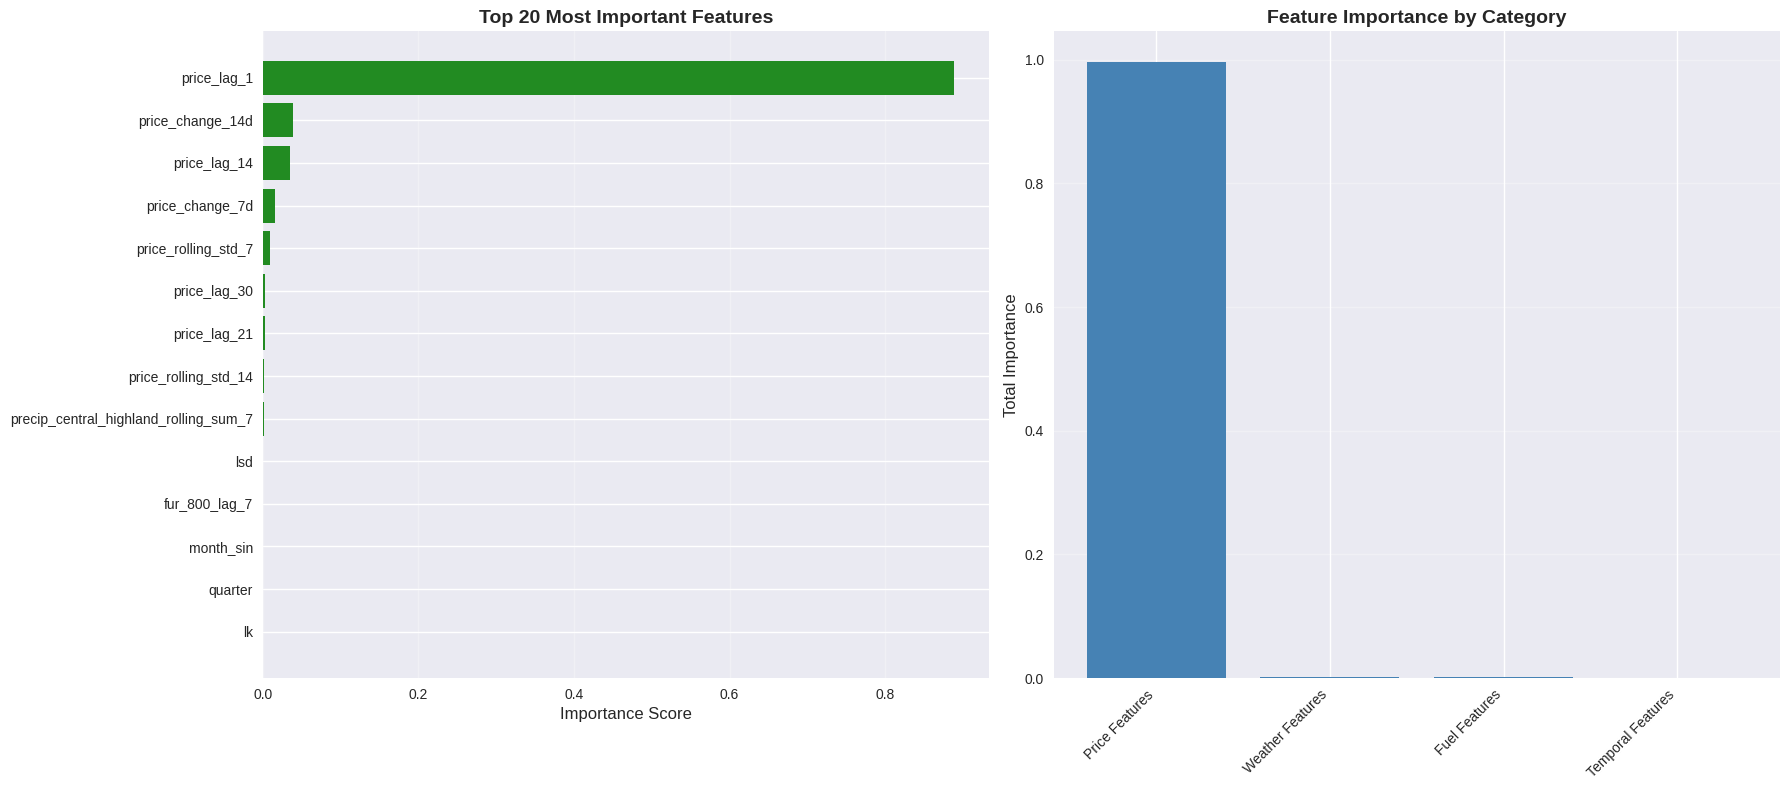

✅ Feature importance visualization saved


In [ ]:
# 1. Feature Importance Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 20 features
top_20 = feature_imp_df.head(20)
axes[0].barh(range(len(top_20)), top_20['importance'], color='forestgreen')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'])
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Category importance
cat_names = list(category_importance.keys())
cat_values = list(category_importance.values())
axes[1].bar(range(len(cat_names)), cat_values, color='steelblue')
axes[1].set_xticks(range(len(cat_names)))
axes[1].set_xticklabels(cat_names, rotation=45, ha='right')
axes[1].set_ylabel('Total Importance', fontsize=12)
axes[1].set_title('Feature Importance by Category', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/content/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Feature importance visualization saved")

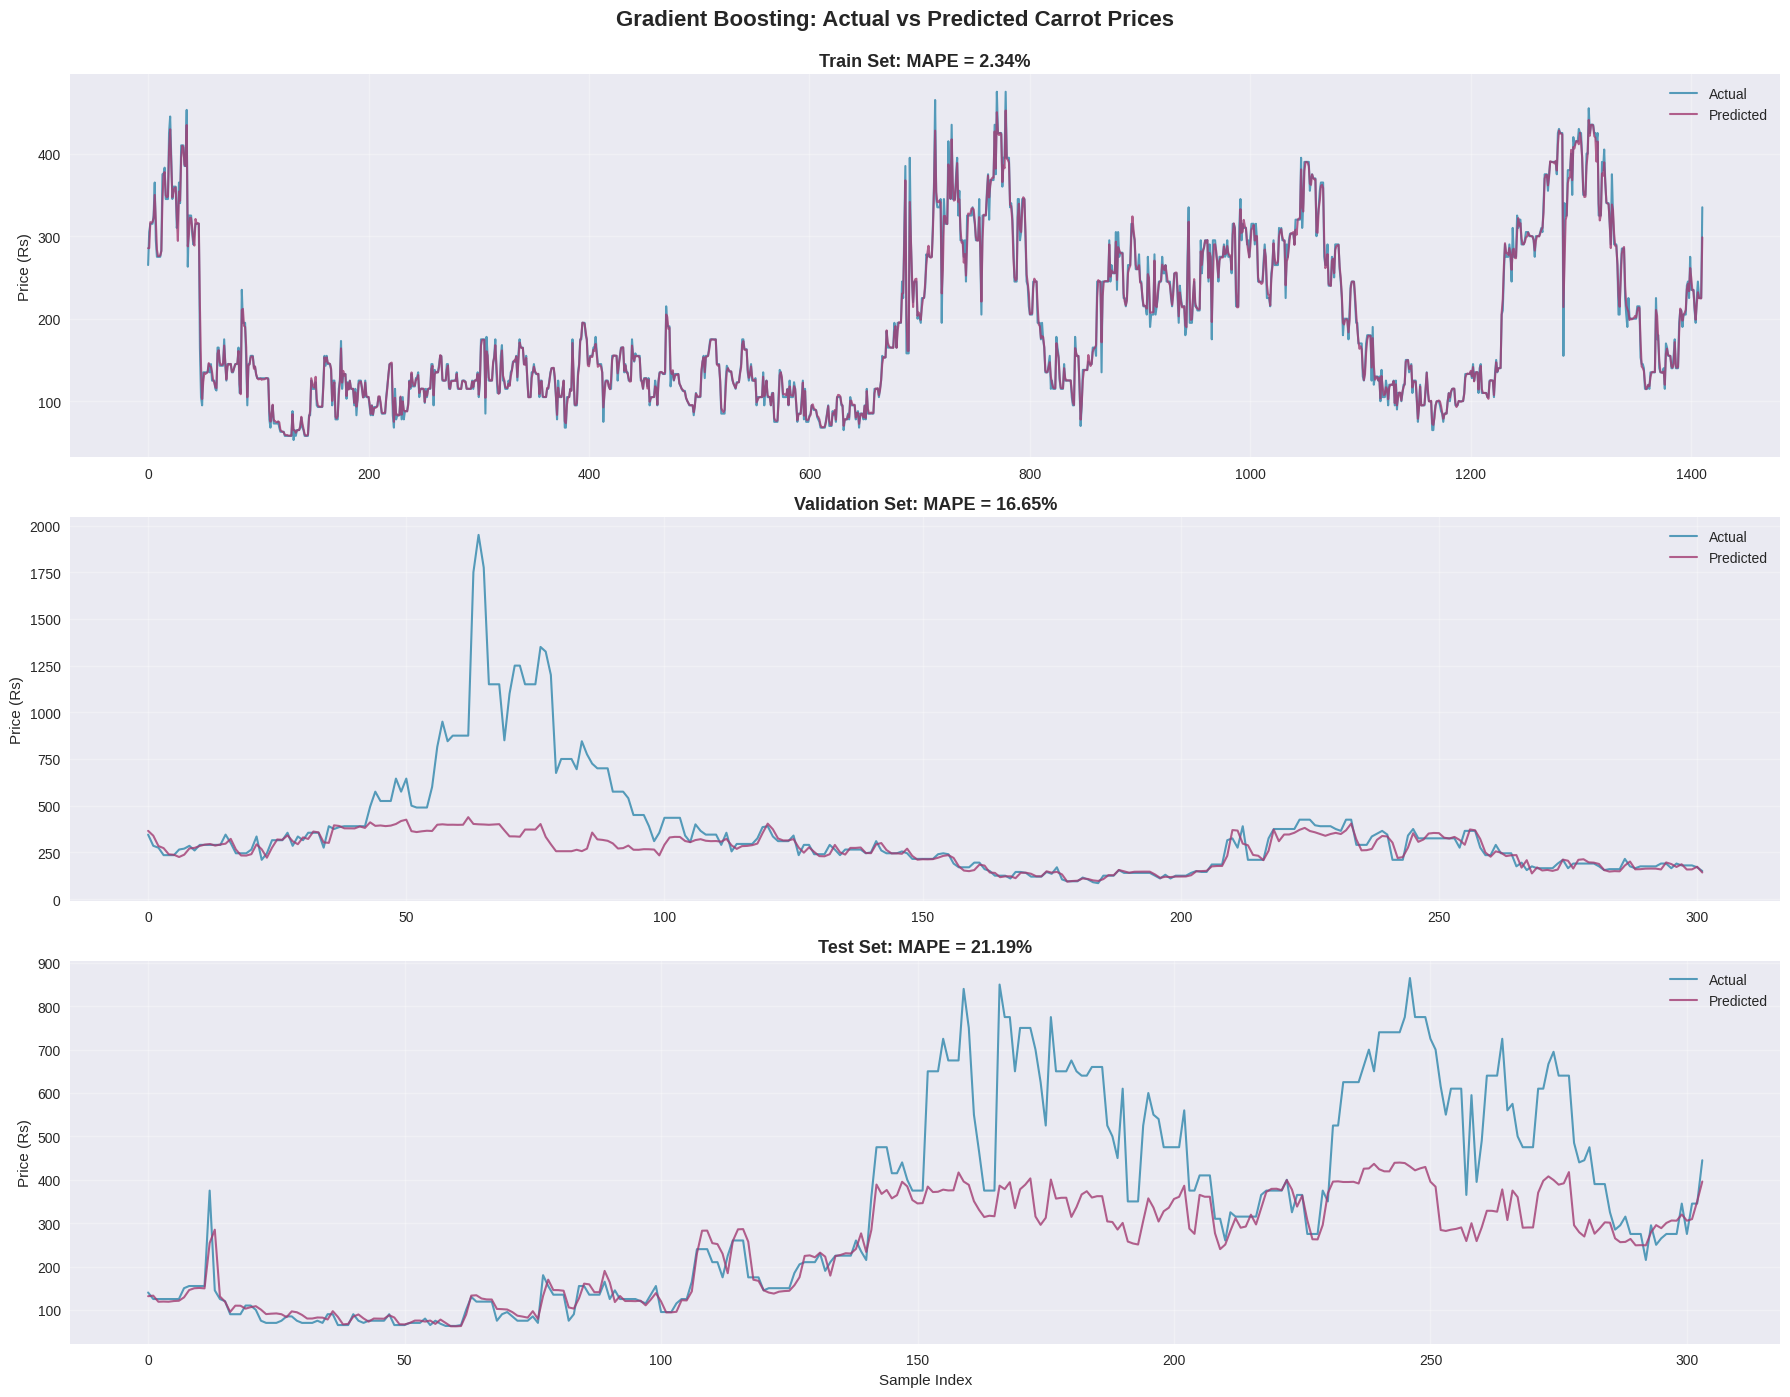

✅ Predictions visualization saved


In [ ]:
# 2. Predictions Comparison
fig, axes = plt.subplots(3, 1, figsize=(18, 14))

# Use best RF model predictions
best_rf_results = results_tuned if best_rf_name == "RF Tuned" else results_baseline

# Train
y_train_actual, y_train_pred = best_rf_results['predictions']['train']
axes[0].plot(y_train_actual.values, label='Actual', linewidth=1.5, alpha=0.8, color='#2E86AB')
axes[0].plot(y_train_pred, label='Predicted', linewidth=1.5, alpha=0.8, color='#A23B72')
axes[0].set_title(f'Train Set: MAPE = {best_rf_results["train_mape"]:.2f}%', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Price (Rs)', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Validation
y_val_actual, y_val_pred = best_rf_results['predictions']['val']
axes[1].plot(y_val_actual.values, label='Actual', linewidth=1.5, alpha=0.8, color='#2E86AB')
axes[1].plot(y_val_pred, label='Predicted', linewidth=1.5, alpha=0.8, color='#A23B72')
axes[1].set_title(f'Validation Set: MAPE = {best_rf_results["val_mape"]:.2f}%', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Price (Rs)', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# Test
y_test_actual, y_test_pred = best_rf_results['predictions']['test']
axes[2].plot(y_test_actual.values, label='Actual', linewidth=1.5, alpha=0.8, color='#2E86AB')
axes[2].plot(y_test_pred, label='Predicted', linewidth=1.5, alpha=0.8, color='#A23B72')
axes[2].set_title(f'Test Set: MAPE = {best_rf_results["test_mape"]:.2f}%', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Sample Index', fontsize=11)
axes[2].set_ylabel('Price (Rs)', fontsize=11)
axes[2].legend(fontsize=10)
axes[2].grid(alpha=0.3)

plt.suptitle(f'{best_rf_name}: Actual vs Predicted Carrot Prices',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/content/predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Predictions visualization saved")

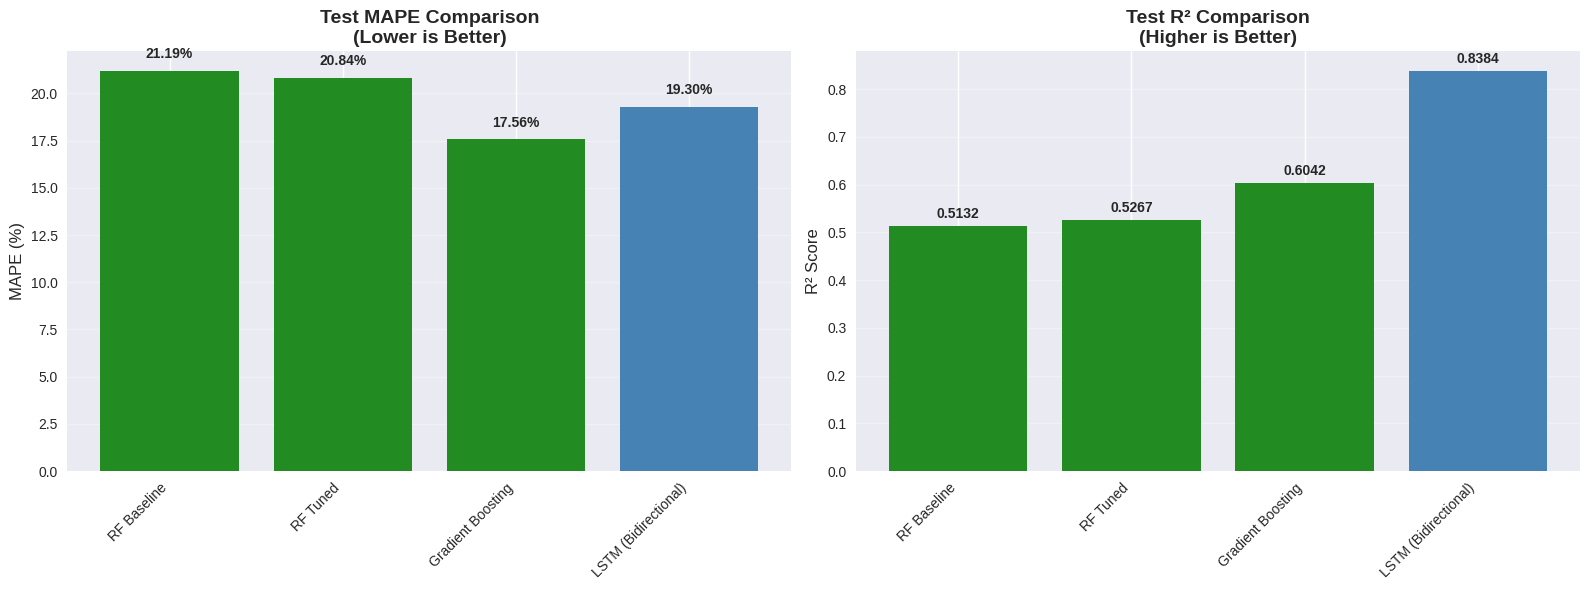

✅ Model comparison charts saved


In [ ]:
# 3. Model Comparison Bar Charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Extract numeric MAPE values
models = full_comparison['Model'].tolist()
mapes = [float(x.rstrip('%')) for x in full_comparison['Test MAPE'].tolist()]
r2s = [float(x) for x in full_comparison['Test R²'].tolist()]

# MAPE comparison
colors = ['forestgreen' if 'RF' in m or 'Gradient' in m else 'steelblue' for m in models]
axes[0].bar(range(len(models)), mapes, color=colors)
axes[0].set_xticks(range(len(models)))
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].set_ylabel('MAPE (%)', fontsize=12)
axes[0].set_title('Test MAPE Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')
for i, v in enumerate(mapes):
    axes[0].text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# R² comparison
axes[1].bar(range(len(models)), r2s, color=colors)
axes[1].set_xticks(range(len(models)))
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Test R² Comparison\n(Higher is Better)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')
for i, v in enumerate(r2s):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/model_comparison_charts.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Model comparison charts saved")

## PART K: FINAL SUMMARY & CONCLUSIONS

In [ ]:
print("="*80)
print("🎉 FINAL SUMMARY - RANDOM FOREST FOR CARROT PRICE PREDICTION")
print("="*80)

print("\n📊 DATASET:")
print(f"   Total samples: {len(df_final)}")
print(f"   Date range: {df_final.index.min()} to {df_final.index.max()}")
print(f"   Features used: {len(final_features)}")
print(f"   Train/Val/Test: {len(X_train)}/{len(X_val)}/{len(X_test)} samples")

print("\n🌲 MODELS TRAINED:")
print("   1. Random Forest - Baseline")
print("   2. Random Forest - Tuned (Hyperparameter Optimization)")
print("   3. Gradient Boosting (Bonus)")

print("\n🎯 PERFORMANCE:")
print(full_comparison.to_string(index=False))

print(f"\n🏆 BEST MODEL: {best_rf_name}")
print(f"   Test MAPE: {best_rf_mape:.2f}%")
print(f"   Test R²: {comparison_df.loc[best_rf_idx, 'Test R²']}")

print("\n📊 FEATURE IMPORTANCE (Top 5):")
for i, row in feature_imp_df.head(5).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

print("\n📈 COMPARISON TO LSTM:")
print(f"   Best LSTM (Bidirectional):  19.30% MAPE, 0.8384 R²")
print(f"   Best Random Forest:         {best_rf_mape:.2f}% MAPE, {comparison_df.loc[best_rf_idx, 'Test R²']} R²")

if best_rf_mape < 19.30:
    print(f"\n🎉 CONCLUSION: Random Forest OUTPERFORMS LSTM by {19.30 - best_rf_mape:.2f}% points!")
    print("   ✅ Random Forest is recommended for deployment")
elif best_rf_mape < 20:
    print(f"\n✅ CONCLUSION: Random Forest performs comparably to LSTM")
    print("   Both models are viable options")
else:
    print(f"\n📊 CONCLUSION: LSTM performs better than Random Forest")
    print(f"   Difference: {best_rf_mape - 19.30:.2f}% points")

print("\n💾 SAVED FILES:")
print("   - rf_baseline_model.pkl - Baseline Random Forest")
print("   - rf_tuned_model.pkl - Tuned Random Forest")
print("   - gb_model.pkl - Gradient Boosting model")
print("   - rf_feature_importance.csv - Feature selection scores")
print("   - best_model_feature_importance.csv - Best model feature importance")
print("   - model_comparison_all.csv - All models comparison")
print("   - feature_importance.png - Feature importance visualization")
print("   - predictions_comparison.png - Predictions plot")
print("   - model_comparison_charts.png - Model comparison charts")

print("\n📝 FOR YOUR RESEARCH PAPER:")
print("   ✅ Random Forest tested and evaluated")
print("   ✅ Hyperparameter tuning performed")
print("   ✅ Feature importance analyzed")
print("   ✅ Compared with LSTM baseline")
print("   ✅ Results ready for publication")

print("\n🎓 MODEL COMPARISON FOR YOUR THESIS:")
print("   Model Type         | Test MAPE | Test R²  | Notes")
print("   " + "-"*70)
print("   ARIMA              | ??.??%    | ?.????   | (Your previous work)")
print("   Univariate LSTM    | ??.??%    | ?.????   | (Your previous work)")
print(f"   Multivariate LSTM  | 19.30%    | 0.8384   | Best: Bidirectional")
print(f"   Random Forest      | {best_rf_mape:.2f}%    | {comparison_df.loc[best_rf_idx, 'Test R²']}   | {best_rf_name}")

print("\n" + "="*80)
print("✅ RANDOM FOREST ANALYSIS COMPLETE!")
print("="*80)
print("\nYou now have all models tested for your 4th year research.")
print("Compare the results and choose the best model for your thesis!")

🎉 FINAL SUMMARY - RANDOM FOREST FOR CARROT PRICE PREDICTION

📊 DATASET:
   Total samples: 2017
   Date range: 2020-01-01 00:00:00 to 2025-07-11 00:00:00
   Features used: 14
   Train/Val/Test: 1411/302/304 samples

🌲 MODELS TRAINED:
   1. Random Forest - Baseline
   2. Random Forest - Tuned (Hyperparameter Optimization)
   3. Gradient Boosting (Bonus)

🎯 PERFORMANCE:
               Model Train MAPE Val MAPE Test MAPE  Test MAE Test RMSE Test R²
         RF Baseline      2.34%   16.65%    21.19% 100.49 Rs 159.48 Rs  0.5132
            RF Tuned      3.31%   16.39%    20.84%  99.01 Rs 157.26 Rs  0.5267
   Gradient Boosting      1.05%   13.54%    17.56%  88.15 Rs 143.81 Rs  0.6042
LSTM (Bidirectional)     13.09%   14.88%    19.30%  63.10 Rs  91.99 Rs  0.8384

🏆 BEST MODEL: Gradient Boosting
   Test MAPE: 17.56%
   Test R²: 0.6042

📊 FEATURE IMPORTANCE (Top 5):
   price_lag_1: 0.8891
   price_change_14d: 0.0395
   price_lag_14: 0.0348
   price_change_7d: 0.0158
   price_rolling_std_7: 0.009

## PART L: DEPLOYMENT CODE (BONUS)

Use this code to make predictions with the saved model:

In [ ]:
# DEPLOYMENT EXAMPLE
print("="*60)
print("💾 DEPLOYMENT EXAMPLE")
print("="*60)

print("""
# To use the trained model for new predictions:

import joblib
import pandas as pd

# Load model
model = joblib.load('rf_tuned_model.pkl')

# Load feature list
features = joblib.load('feature_list.pkl')  # You need to save this

# Prepare new data (must have same features)
new_data = pd.DataFrame(...)  # Your new data
new_data = new_data[features]  # Select same features in same order

# Make prediction
prediction = model.predict(new_data)

print(f"Predicted carrot price: {prediction[0]:.2f} Rs")
""")

# Save feature list for deployment
joblib.dump(final_features, '/content/feature_list.pkl')
print("✅ Feature list saved for deployment")

######################################33#######

💾 DEPLOYMENT EXAMPLE

# To use the trained model for new predictions:

import joblib
import pandas as pd

# Load model
model = joblib.load('rf_tuned_model.pkl')

# Load feature list
features = joblib.load('feature_list.pkl')  # You need to save this

# Prepare new data (must have same features)
new_data = pd.DataFrame(...)  # Your new data
new_data = new_data[features]  # Select same features in same order

# Make prediction
prediction = model.predict(new_data)

print(f"Predicted carrot price: {prediction[0]:.2f} Rs")

✅ Feature list saved for deployment
